In [1]:
# Import the libraries for data visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the libraries for bulding the model
from sklearn.linear_model import LinearRegression

# Import the libraries for testing and metric measurements
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Import the final working data
final_df = pd.read_csv('final_data.csv', index_col = 0)

C:\Users\Eric\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# Import the final test data
final_test = pd.read_csv('final_test_data.csv',index_col = 0)

In [4]:
# Try out the model with the grouped shops and grouped item categories 
# training_final_df = final_df[['year', 'month', 'Shop Group', 'Item Category Group', 'item_cnt_day']]
# group_df = training_final_df.groupby(['year', 'month', 'Shop Group', 'Item Category Group'], as_index=False).sum()


# Try out the model without the grouped shops (shop_id and grouped item_category_id)
training_final_df = final_df[['year', 'month', 'shop_id', 'Item Category Group', 'item_cnt_day']]
group_df = training_final_df.groupby(['year', 'month', 'shop_id', 'Item Category Group'], as_index=False).sum()


# Try out the model without any groups (shop_id and item_category_id)
# group_df = final_df.groupby(['year', 'month', 'shop_id', 'item_category_id'], as_index=False)[['item_cnt_day']].sum()


# Try out the model with newly grouped item_ids (shop_id and grouped item_ids)
# group_df = final_df.groupby(['year', 'month', 'shop_id', 'item_group'], as_index=False)[['item_cnt_day']].sum()

# Taking the average of the months with grouped item_ids
# year_df = final_df.groupby(['year', 'month', 'shop_id', 'item_group'], as_index=False)[['item_cnt_day']].sum()
# group_df = year_df.groupby(['month', 'shop_id', 'item_group'], as_index=False)[['item_cnt_day']].mean()

In [5]:
group_df.describe()

,year,month,shop_id,Item Category Group,item_cnt_day
count,25611.000000,25611.000000,25611.000000,25611.000000,25611.000000
mean,2013.957128,6.249580,31.054820,27.080668,142.460974
std,0.786079,3.344298,17.238519,23.544164,214.138249
min,2013.000000,1.000000,0.000000,0.000000,-1.000000
25%,2013.000000,3.000000,16.000000,4.000000,33.000000
50%,2014.000000,6.000000,30.000000,23.000000,80.000000
75%,2015.000000,9.000000,46.000000,40.000000,165.000000
max,2015.000000,12.000000,59.000000,71.000000,5129.000000


In [6]:
# Split the data into X (variables) and y (target)
X = group_df.drop('item_cnt_day', axis=1)
y = group_df['item_cnt_day']

# Create the dummy variables and remove the original column from the X data
for col in X.columns:
    group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
    X = X.join(group_dummies)
    del X[col]

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21, stratify=group_df['month'])

In [8]:
# Create a baseline at Jul. 2014
baseline_jul = group_df[(group_df['year'] == 2014) & (group_df['month'] == 7)].copy()

# Create another baseline for just July
# baseline_jul = group_df[group_df['month'] == 7].copy()

# Split the baseline data into X and y components
baselineX = baseline_jul.drop('item_cnt_day', axis=1)
baseliney = baseline_jul['item_cnt_day']

# Create the dummy variables and remove the original column from the baseline X data
for col in baselineX.columns:
    group_dummies = pd.get_dummies(baselineX[col]).rename(columns=lambda x: col + str(x))
    baselineX = baselineX.join(group_dummies)
    del baselineX[col]
    
# Add columns to the baseline data to use for prediction
for i in X_train:
    if i not in baselineX:
        baselineX[i] = 0
        
# Rearrange the columns
baselineX = baselineX[X_train.columns]

In [9]:
# Initialze and fit the linear regression model
trained_linreg = LinearRegression()
trained_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0,0.5,'Frequency')

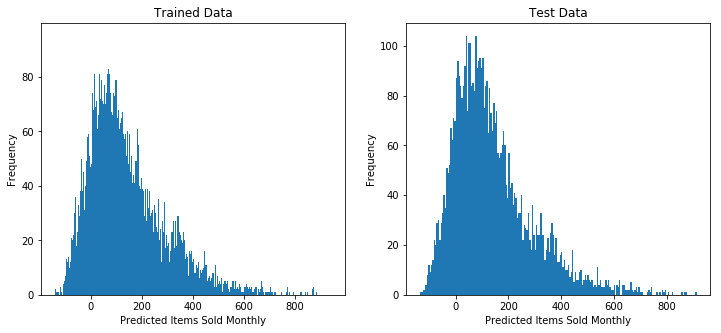

In [10]:
# Plot the predicted train and test values on histograms to observe the distribution

# Assign the predicted values to a variable
predicted_train_values = trained_linreg.predict(X_train)
predicted_test_values = trained_linreg.predict(X_test)

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the trained values
ax1.hist(predicted_train_values, bins=1000)
ax1.set_title('Trained Data')
ax1.set_xlabel('Predicted Items Sold Monthly')
ax1.set_ylabel('Frequency')

# Plot the test values
ax2.hist(predicted_test_values, bins=200)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted Items Sold Monthly')
ax2.set_ylabel('Frequency')

# Both data are right skewed

Text(0,0.5,'Predicted Monthly Items Sold')

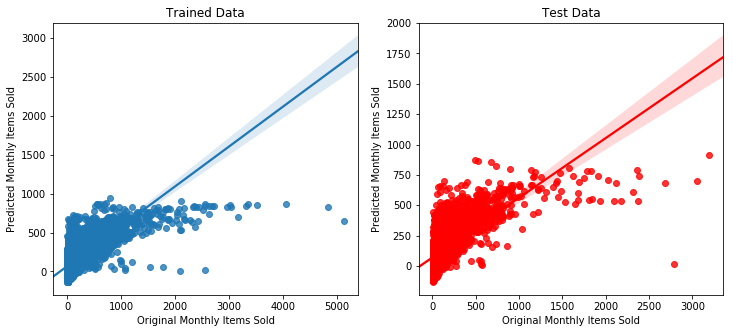

In [11]:
# Plot the original count vs. the predicted count of the training and test data on a scatter plot

# Plot the scatterplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the trained values
sns.regplot(x=y_train, y=predicted_train_values, ax=ax1)
ax1.set_title('Trained Data')
ax1.set_xlabel('Original Monthly Items Sold')
ax1.set_ylabel('Predicted Monthly Items Sold')

# Plot the test values
sns.regplot(x=y_test, y=predicted_test_values, ax=ax2, color='r')
ax2.set_title('Test Data')
ax2.set_xlabel('Original Monthly Items Sold')
ax2.set_ylabel('Predicted Monthly Items Sold')

# It appears that our model has a tendency to underestimate. There appears to be a large amount of negative predictions

In [12]:
# Let's look at the RMSE and R^2 value for the model with the training data
trainRMSE = np.sqrt(mean_squared_error(y_train, predicted_train_values))

print ('Training Data    \nRoot Mean Squared Error:', trainRMSE)
print ('R^2:', trained_linreg.score(X_train, y_train))

Training Data    
Root Mean Squared Error: 148.62569243345519
R^2: 0.5128853682112857


In [13]:
# Let's look at the RMSE and R^2 value for the model with the test data
testRMSE = np.sqrt(mean_squared_error(y_test, predicted_test_values))

print ('Test Data    \nRoot Mean Squared Error:', testRMSE)
print ('R^2:', trained_linreg.score(X_test, y_test))

Test Data    
Root Mean Squared Error: 154.30298795190114
R^2: 0.5026778306313113


In [14]:
# Let's look at the RMSE and R^2 value for the model using the baseline data at Jul 2014
baselinePrediction = trained_linreg.predict(baselineX)
baselineRMSE = np.sqrt(mean_squared_error(baseliney, baselinePrediction))

print ('Baseline Data    \nRoot Mean Squared Error:', baselineRMSE)
print ('R^2:', trained_linreg.score(baselineX, baseliney))

Baseline Data    
Root Mean Squared Error: 96.48188275474409
R^2: 0.5574164950377026


In [15]:
final_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year,Shop Group,Item Category Group
count,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06,2.936211e+06
mean,1.456947e+01,3.300149e+01,1.019723e+04,8.906756e+02,1.242611e+00,4.000220e+01,6.248428e+00,2.013777e+03,1.465885e+01,2.834390e+01
std,9.422488e+00,1.622598e+01,6.324322e+03,1.720396e+03,2.618674e+00,1.710090e+01,3.536580e+00,7.684800e-01,1.760313e+01,1.882901e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,-2.200000e+01,0.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01,3.000000e+00,2.013000e+03,3.000000e+00,5.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01,6.000000e+00,2.014000e+03,4.000000e+00,3.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01,9.000000e+00,2.014000e+03,2.800000e+01,4.000000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,2.169000e+03,8.300000e+01,1.200000e+01,2.015000e+03,5.700000e+01,7.100000e+01


In [16]:
final_test.describe()

,shop_id,item_id,item_category_id,Item Category Group,Shop Group,item_group,year,month
count,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000,214200.0,214200.0
mean,31.642857,11019.398627,46.309608,22.908824,6.476190,130.516275,2015.0,11.0
std,17.561933,6252.644590,16.716581,21.400172,11.846743,1179.420647,0.0,0.0
min,2.000000,30.000000,0.000000,0.000000,0.000000,0.000000,2015.0,11.0
25%,16.000000,5381.500000,37.000000,4.000000,2.000000,2.000000,2015.0,11.0
50%,34.500000,11203.000000,43.000000,19.000000,3.000000,10.000000,2015.0,11.0
75%,47.000000,16071.500000,58.000000,40.000000,4.000000,12.000000,2015.0,11.0
max,59.000000,22167.000000,83.000000,71.000000,57.000000,22088.000000,2015.0,11.0


In [17]:
# For the model with grouped shop and item category
# test_df = final_test[['year', 'month', 'Shop Group', 'Item Category Group']]

# For the model with only grouped item category
# test_df = final_test[['year', 'month', 'shop_id', 'Item Category Group']]

# For the model with no groups
# test_df = final_test[['year', 'month', 'shop_id', 'item_category_id']]

# For the model with grouped item ids
test_df = final_test[['year', 'month', 'shop_id', 'item_group']]

# For the model with grouped item ids and averaged months
# test_df = final_test[['month', 'shop_id', 'item_group']]

In [18]:
# Create the dummy variables and remove the original column from the test data
for col in test_df:
    group_dummies = pd.get_dummies(test_df[col]).rename(columns=lambda x: col + str(x))
    test_df = test_df.join(group_dummies)
    del test_df[col]
    
# Add columns to the test data to use for prediction
for i in X_train:
    if i not in test_df:
        test_df[i] = 0
        
# Rearrange the columns
test_df = test_df[X_train.columns]

In [19]:
# Make the prediction for the double group and export it
# twoGroup = trained_linreg.predict(test_df)
# doubleGroup = pd.DataFrame(twoGroup, columns=['item_cnt_month'])
# doubleGroup.to_csv('Double_group_prediction.csv')


# Make a prediction for the item category group and export it
# singleGroup = trained_linreg.predict(test_df)
# oneGroup = pd.DataFrame(singleGroup, columns=['item_cnt_month'])
# oneGroup.to_csv('single_group_prediction.csv')


# Make a prediction for the no groups and export it
# noneGroup = trained_linreg.predict(test_df)
# noGroup = pd.DataFrame(noneGroup, columns=['item_cnt_month'])
# noGroup.to_csv('no_group_prediction.csv')


# Make a prediction for the grouped item_id and export it 
itemGroups = trained_linreg.predict(test_df)
itemID = pd.DataFrame(itemGroups, columns=['item_cnt_month'])
itemID.to_csv('group_itemID_prediction.csv')


# Make a prediction for grouped item_id and averaged months and export it
# avgMonth = trained_linreg.predict(test_df)
# avgMonth_itemID = pd.DataFrame(avgMonth, columns=['item_cnt_month'])
# avgMonth_itemID.to_csv('avgMonth_itemID_prediction.csv')